In [1]:
from PIL import Image
import os.path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import random

C:\Users\Public\Downloads\Anaconda\envs\AMLS\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Public\Downloads\Anaconda\envs\AMLS\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Public\Downloads\Anaconda\envs\AMLS\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Public\Downloads\Anaconda\envs\AMLS\l

In [2]:
def get_data():
    X=[]
    y=[]
    baseDir = os.path.abspath('..')
    filePath = os.path.join(baseDir ,'Datasets','cartoon_set','img')
    filelist = os.listdir(filePath)
    labelPath = os.path.join(baseDir ,'Datasets','cartoon_set','labels.csv') 
    labels = pd.read_csv(labelPath,delimiter = '\t')
    kernel = np.ones((3,3),np.uint8) 
    for item in filelist:
        path = os.path.join(filePath,item)
        img= cv2.imread(path)
        #extract eye area and resize into 20*20
        eye = img[220:300,150:250]
        img = cv2.resize(eye, (20, 20))
        #data normalization
        X.append(img/255.)
        zero = np.zeros([5])
        #one-hot encoding
        zero[int(labels['eye_color'][int(item.split('.')[0])])] = 1
        y.append(zero)
    Y = np.array(y)
    x_train, x_test, y_train, y_test = train_test_split(X, Y,random_state=0)

    return x_train, x_test, y_train, y_test

In [3]:
def allocate_weights_and_biases():

    #define convolution kernal numbers and neurons in hidden layers
    kernal_1 = 16
    kernal_2 = 32
    n_hidden_1 = 512  
    n_hidden_2 = 128  
    
    #set placeholder for input and output
    X = tf.placeholder("float", [None, 20, 20, 3],name = 'input_images')
    Y = tf.placeholder("float", [None, 5],name = 'result')  # 5 output classes
    x_input = tf.reshape(X,[-1,20,20,3])
    stddev = 0.01
    
    #assign weights and biases on each layer
    weights = {
        'conv_layer1':tf.Variable(tf.random_normal([3,3,3,kernal_1], stddev=stddev)),
        'conv_layer2':tf.Variable(tf.random_normal([3,3,kernal_1,kernal_2], stddev=stddev)),
        'hidden_layer1': tf.Variable(tf.random_normal([800, n_hidden_1], stddev=stddev)),
        'hidden_layer2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
        'out': tf.Variable(tf.random_normal([n_hidden_2, 5], stddev=stddev))
    }

    biases = {
        'bias_ConvLayer1':tf.Variable(tf.random_normal([kernal_1], stddev=stddev)),
        'bias_ConvLayer2':tf.Variable(tf.random_normal([kernal_2], stddev=stddev)),
        'bias_layer1': tf.Variable(tf.random_normal([n_hidden_1], stddev=stddev)),
        'bias_layer2': tf.Variable(tf.random_normal([n_hidden_2], stddev=stddev)),
        'out': tf.Variable(tf.random_normal([5], stddev=stddev))
    }
    
    return weights, biases, X, Y,x_input
    

In [4]:
def multilayer_perceptron():
        
    weights, biases, X, Y, x_input = allocate_weights_and_biases()
    
    #build and connect layers
    layer_1 = tf.add(tf.nn.conv2d(x_input, weights['conv_layer1'],strides=[1,1,1,1],padding='SAME'), biases['bias_ConvLayer1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.max_pool(layer_1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

    layer_2 = tf.add(tf.nn.conv2d(layer_1, weights['conv_layer2'],strides=[1,1,1,1],padding='SAME'), biases['bias_ConvLayer2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_2 = tf.nn.max_pool(layer_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    flat =  tf.contrib.layers.flatten(layer_2)  
    full_layer1 = tf.add(tf.matmul(flat,weights['hidden_layer1']),biases['bias_layer1'])
    full_layer1 = tf.nn.relu(full_layer1)
    full_layer1 = tf.nn.dropout(full_layer1,0.5)
    
    full_layer2 = tf.add(tf.matmul(full_layer1,weights['hidden_layer2']),biases['bias_layer2'])
    full_layer2 = tf.nn.relu(full_layer2)
    full_layer2 = tf.nn.dropout(full_layer2,0.5)
    
    out_layer = tf.matmul(full_layer2, weights['out']) + biases['out']
    out_layer = tf.nn.softmax(out_layer)

    return out_layer, X, Y

In [5]:
x_train, x_test, y_train, y_test = get_data()

In [7]:
global_step = tf.Variable(0, trainable=False)
#set learning rate, training epochs adn model save step.
learning_rate = tf.train.exponential_decay(1e-3,  global_step, decay_steps=500, decay_rate=0.5,staircase=True)
display_accuracy_step = 10
training_epochs = 10000
save_step = 2000

In [8]:
logits, X, Y = multilayer_perceptron()
#build tensors including loss,acc and predict_label
variables   = tf.trainable_variables() 
lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in variables ]) * 1e-5
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y)+lossL2)
predict_label = tf.argmax(logits, 1,name = 'predict_label')
true_prediction = tf.equal(predict_label, tf.argmax(Y, 1),name = 'check')
acc = tf.reduce_mean(tf.cast(true_prediction, "float"),name = 'acc')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
init_op = tf.global_variables_initializer()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [9]:
with tf.Session() as sess:
    saver = tf.train.Saver(max_to_keep=4)
    sess.run(init_op)
    train_acc=[]
    val_acc = []
    for epoch in range(training_epochs):
        #set batch components
        idx=random.randint(0,7372)
        batch= random.randint(64,129)
        train_input = x_train[idx:(idx+batch)]
        train_labels = y_train[idx:(idx+batch)]
        accuracy,_, cost = sess.run([acc,train_op, loss_op], feed_dict={X: train_input,Y: train_labels})
        print("Epoch:", '%04d' % (epoch + 1), "cost={:.9f}".format(cost))
        #add acc into arrays and wait for visualization
        train_acc.append(acc.eval({X: x_train,Y: y_train}))
        val_acc.append(acc.eval({X: x_test,Y: y_test}))
        if epoch % display_accuracy_step == 0:
            print("Accuracy: {:.3f}".format(accuracy))
        if ((epoch+1) % save_step == 0):
            saver.save(sess, "models/eye-model", global_step=epoch)
    print("Optimization Finished!")
    print("Test Accuracy:", acc.eval({X: x_test,Y: y_test}))

Epoch: 0001 cost=1.609449983
Accuracy: 0.247
Epoch: 0002 cost=1.609539390
Epoch: 0003 cost=1.609203696
Epoch: 0004 cost=1.609504819
Epoch: 0005 cost=1.609653473
Epoch: 0006 cost=1.609342933
Epoch: 0007 cost=1.609864116
Epoch: 0008 cost=1.609592438
Epoch: 0009 cost=1.610198855
Epoch: 0010 cost=1.609861970
Epoch: 0011 cost=1.609783888
Accuracy: 0.148
Epoch: 0012 cost=1.609943628
Epoch: 0013 cost=1.609595418
Epoch: 0014 cost=1.609719276
Epoch: 0015 cost=1.609470963
Epoch: 0016 cost=1.609687686
Epoch: 0017 cost=1.609164834
Epoch: 0018 cost=1.609154940
Epoch: 0019 cost=1.609604359
Epoch: 0020 cost=1.609800935
Epoch: 0021 cost=1.609824181
Accuracy: 0.157
Epoch: 0022 cost=1.609272838
Epoch: 0023 cost=1.609376669
Epoch: 0024 cost=1.608973861
Epoch: 0025 cost=1.608902693
Epoch: 0026 cost=1.610139608
Epoch: 0027 cost=1.609003544
Epoch: 0028 cost=1.609312773
Epoch: 0029 cost=1.609753251
Epoch: 0030 cost=1.609174132
Epoch: 0031 cost=1.609549761
Accuracy: 0.193
Epoch: 0032 cost=1.609959483
Epoch: 0

Epoch: 0270 cost=1.219802260
Epoch: 0271 cost=1.115560889
Accuracy: 0.805
Epoch: 0272 cost=1.118438363
Epoch: 0273 cost=1.128830552
Epoch: 0274 cost=1.113854408
Epoch: 0275 cost=1.141902328
Epoch: 0276 cost=1.120504379
Epoch: 0277 cost=1.108963370
Epoch: 0278 cost=1.179411054
Epoch: 0279 cost=1.127205610
Epoch: 0280 cost=1.162923813
Epoch: 0281 cost=1.156987667
Accuracy: 0.769
Epoch: 0282 cost=1.146445990
Epoch: 0283 cost=1.206936121
Epoch: 0284 cost=1.173045754
Epoch: 0285 cost=1.149242997
Epoch: 0286 cost=1.210063934
Epoch: 0287 cost=1.158934355
Epoch: 0288 cost=1.162685394
Epoch: 0289 cost=1.207636595
Epoch: 0290 cost=1.123963952
Epoch: 0291 cost=1.127718091
Accuracy: 0.816
Epoch: 0292 cost=1.108964086
Epoch: 0293 cost=1.062369347
Epoch: 0294 cost=1.057600260
Epoch: 0295 cost=1.098075986
Epoch: 0296 cost=1.095682979
Epoch: 0297 cost=1.126024604
Epoch: 0298 cost=1.009820461
Epoch: 0299 cost=1.048038363
Epoch: 0300 cost=1.140959144
Epoch: 0301 cost=1.134603739
Accuracy: 0.778
Epoch: 0

Epoch: 0540 cost=1.149700522
Epoch: 0541 cost=1.013347745
Accuracy: 0.904
Epoch: 0542 cost=1.164246798
Epoch: 0543 cost=1.088401079
Epoch: 0544 cost=1.050268888
Epoch: 0545 cost=1.059609175
Epoch: 0546 cost=1.086737514
Epoch: 0547 cost=1.067942619
Epoch: 0548 cost=1.083566546
Epoch: 0549 cost=1.094896913
Epoch: 0550 cost=1.056728244
Epoch: 0551 cost=1.047470093
Accuracy: 0.847
Epoch: 0552 cost=1.085875511
Epoch: 0553 cost=1.069190860
Epoch: 0554 cost=1.038428068
Epoch: 0555 cost=1.101843238
Epoch: 0556 cost=1.095511556
Epoch: 0557 cost=1.077385187
Epoch: 0558 cost=1.076830745
Epoch: 0559 cost=1.074241877
Epoch: 0560 cost=1.124343395
Epoch: 0561 cost=1.111635685
Accuracy: 0.778
Epoch: 0562 cost=1.064251661
Epoch: 0563 cost=1.092975140
Epoch: 0564 cost=1.099344850
Epoch: 0565 cost=1.152540207
Epoch: 0566 cost=1.135511875
Epoch: 0567 cost=1.085855722
Epoch: 0568 cost=1.011063814
Epoch: 0569 cost=1.089523911
Epoch: 0570 cost=1.069182873
Epoch: 0571 cost=1.105575204
Accuracy: 0.803
Epoch: 0

Epoch: 0808 cost=1.072661638
Epoch: 0809 cost=1.072625041
Epoch: 0810 cost=1.102887154
Epoch: 0811 cost=1.078552365
Accuracy: 0.836
Epoch: 0812 cost=1.040448427
Epoch: 0813 cost=0.985096157
Epoch: 0814 cost=1.093917012
Epoch: 0815 cost=1.051677465
Epoch: 0816 cost=1.009262800
Epoch: 0817 cost=1.097723126
Epoch: 0818 cost=1.099325299
Epoch: 0819 cost=1.070567369
Epoch: 0820 cost=1.093849301
Epoch: 0821 cost=1.085496426
Accuracy: 0.809
Epoch: 0822 cost=1.073974848
Epoch: 0823 cost=1.088381648
Epoch: 0824 cost=1.074457407
Epoch: 0825 cost=1.137684941
Epoch: 0826 cost=1.043354869
Epoch: 0827 cost=1.117785931
Epoch: 0828 cost=1.113933802
Epoch: 0829 cost=1.099915624
Epoch: 0830 cost=1.026971221
Epoch: 0831 cost=1.030018210
Accuracy: 0.880
Epoch: 0832 cost=1.064384460
Epoch: 0833 cost=1.045524478
Epoch: 0834 cost=1.025339246
Epoch: 0835 cost=1.068523765
Epoch: 0836 cost=1.065267324
Epoch: 0837 cost=1.107401848
Epoch: 0838 cost=1.098298311
Epoch: 0839 cost=1.124688745
Epoch: 0840 cost=1.08948

Epoch: 1077 cost=1.128449678
Epoch: 1078 cost=1.088506937
Epoch: 1079 cost=1.061888576
Epoch: 1080 cost=1.082702756
Epoch: 1081 cost=1.065334558
Accuracy: 0.809
Epoch: 1082 cost=1.123684883
Epoch: 1083 cost=1.056932092
Epoch: 1084 cost=1.071800947
Epoch: 1085 cost=1.127065182
Epoch: 1086 cost=1.069360971
Epoch: 1087 cost=1.010708570
Epoch: 1088 cost=1.059210300
Epoch: 1089 cost=1.068029523
Epoch: 1090 cost=1.099391103
Epoch: 1091 cost=1.093012214
Accuracy: 0.833
Epoch: 1092 cost=1.066186666
Epoch: 1093 cost=1.072360516
Epoch: 1094 cost=1.090951920
Epoch: 1095 cost=1.034896731
Epoch: 1096 cost=1.065441370
Epoch: 1097 cost=1.071043253
Epoch: 1098 cost=1.092168212
Epoch: 1099 cost=1.059404254
Epoch: 1100 cost=1.093511820
Epoch: 1101 cost=1.041326761
Accuracy: 0.841
Epoch: 1102 cost=1.066523433
Epoch: 1103 cost=1.049433947
Epoch: 1104 cost=1.105635643
Epoch: 1105 cost=1.066575527
Epoch: 1106 cost=1.057206035
Epoch: 1107 cost=1.058924437
Epoch: 1108 cost=1.054729939
Epoch: 1109 cost=1.10380

Epoch: 1347 cost=1.075809598
Epoch: 1348 cost=1.039976954
Epoch: 1349 cost=1.109759927
Epoch: 1350 cost=1.070084214
Epoch: 1351 cost=1.050227165
Accuracy: 0.877
Epoch: 1352 cost=1.099578381
Epoch: 1353 cost=1.089642882
Epoch: 1354 cost=1.053179622
Epoch: 1355 cost=1.044220090
Epoch: 1356 cost=1.040868163
Epoch: 1357 cost=1.044694066
Epoch: 1358 cost=1.048413515
Epoch: 1359 cost=1.062365532
Epoch: 1360 cost=1.091006160
Epoch: 1361 cost=1.025640011
Accuracy: 0.892
Epoch: 1362 cost=1.050339937
Epoch: 1363 cost=1.126675844
Epoch: 1364 cost=1.072232962
Epoch: 1365 cost=1.100549698
Epoch: 1366 cost=1.096493721
Epoch: 1367 cost=1.060189605
Epoch: 1368 cost=1.025224209
Epoch: 1369 cost=1.090459228
Epoch: 1370 cost=1.040515542
Epoch: 1371 cost=1.002819777
Accuracy: 0.882
Epoch: 1372 cost=1.048594117
Epoch: 1373 cost=1.029783130
Epoch: 1374 cost=1.059882641
Epoch: 1375 cost=1.096619129
Epoch: 1376 cost=1.084022045
Epoch: 1377 cost=1.064808130
Epoch: 1378 cost=1.120271444
Epoch: 1379 cost=1.10536

Epoch: 1615 cost=1.119283557
Epoch: 1616 cost=1.044684410
Epoch: 1617 cost=1.071988583
Epoch: 1618 cost=1.072055578
Epoch: 1619 cost=1.114682078
Epoch: 1620 cost=1.077350616
Epoch: 1621 cost=1.049033642
Accuracy: 0.878
Epoch: 1622 cost=1.064797521
Epoch: 1623 cost=1.088474631
Epoch: 1624 cost=1.054794073
Epoch: 1625 cost=1.088101983
Epoch: 1626 cost=1.075056672
Epoch: 1627 cost=1.097408652
Epoch: 1628 cost=1.123053312
Epoch: 1629 cost=1.033127546
Epoch: 1630 cost=1.004408717
Epoch: 1631 cost=1.035541534
Accuracy: 0.873
Epoch: 1632 cost=1.074650526
Epoch: 1633 cost=1.043684125
Epoch: 1634 cost=1.056381583
Epoch: 1635 cost=1.014963865
Epoch: 1636 cost=1.119989514
Epoch: 1637 cost=1.093019366
Epoch: 1638 cost=1.042084694
Epoch: 1639 cost=1.125219584
Epoch: 1640 cost=1.049556017
Epoch: 1641 cost=1.039683223
Accuracy: 0.852
Epoch: 1642 cost=1.114530206
Epoch: 1643 cost=1.080991507
Epoch: 1644 cost=1.058626294
Epoch: 1645 cost=1.051285863
Epoch: 1646 cost=1.046092272
Epoch: 1647 cost=1.07996

Epoch: 1884 cost=1.042821050
Epoch: 1885 cost=1.107226014
Epoch: 1886 cost=1.086847901
Epoch: 1887 cost=1.090372801
Epoch: 1888 cost=1.087171555
Epoch: 1889 cost=1.100852609
Epoch: 1890 cost=1.055324674
Epoch: 1891 cost=1.080692768
Accuracy: 0.798
Epoch: 1892 cost=1.060966969
Epoch: 1893 cost=1.048846126
Epoch: 1894 cost=1.088665247
Epoch: 1895 cost=1.029559493
Epoch: 1896 cost=1.045145988
Epoch: 1897 cost=1.074452996
Epoch: 1898 cost=1.018456221
Epoch: 1899 cost=1.044913530
Epoch: 1900 cost=1.031893730
Epoch: 1901 cost=1.034487605
Accuracy: 0.862
Epoch: 1902 cost=1.064724445
Epoch: 1903 cost=1.087404490
Epoch: 1904 cost=1.057903767
Epoch: 1905 cost=1.062680602
Epoch: 1906 cost=1.031650066
Epoch: 1907 cost=1.044386744
Epoch: 1908 cost=1.070092201
Epoch: 1909 cost=1.030296683
Epoch: 1910 cost=1.053466201
Epoch: 1911 cost=1.061031580
Accuracy: 0.838
Epoch: 1912 cost=1.035563350
Epoch: 1913 cost=0.985270560
Epoch: 1914 cost=1.076882839
Epoch: 1915 cost=1.009827375
Epoch: 1916 cost=0.99043

Epoch: 2153 cost=1.089976072
Epoch: 2154 cost=1.044154525
Epoch: 2155 cost=1.111140847
Epoch: 2156 cost=1.119494915
Epoch: 2157 cost=1.084273934
Epoch: 2158 cost=1.113543272
Epoch: 2159 cost=1.122971296
Epoch: 2160 cost=1.055674911
Epoch: 2161 cost=1.088150144
Accuracy: 0.795
Epoch: 2162 cost=1.093990445
Epoch: 2163 cost=1.078428864
Epoch: 2164 cost=1.030784965
Epoch: 2165 cost=1.038147569
Epoch: 2166 cost=1.095636129
Epoch: 2167 cost=1.065941215
Epoch: 2168 cost=1.064763904
Epoch: 2169 cost=1.085871339
Epoch: 2170 cost=1.070080161
Epoch: 2171 cost=1.022271633
Accuracy: 0.877
Epoch: 2172 cost=1.031897902
Epoch: 2173 cost=1.026168704
Epoch: 2174 cost=1.066281557
Epoch: 2175 cost=1.035261869
Epoch: 2176 cost=1.073052764
Epoch: 2177 cost=1.106234670
Epoch: 2178 cost=1.041469216
Epoch: 2179 cost=1.056523442
Epoch: 2180 cost=1.041837931
Epoch: 2181 cost=1.109331131
Accuracy: 0.757
Epoch: 2182 cost=1.089181304
Epoch: 2183 cost=1.075284123
Epoch: 2184 cost=1.049644113
Epoch: 2185 cost=1.13286

Epoch: 2424 cost=1.053049088
Epoch: 2425 cost=1.049722314
Epoch: 2426 cost=1.075956941
Epoch: 2427 cost=1.033600688
Epoch: 2428 cost=1.107891798
Epoch: 2429 cost=1.077394605
Epoch: 2430 cost=1.114038110
Epoch: 2431 cost=1.107218504
Accuracy: 0.784
Epoch: 2432 cost=1.057679415
Epoch: 2433 cost=1.037470937
Epoch: 2434 cost=1.046394110
Epoch: 2435 cost=1.053566694
Epoch: 2436 cost=1.035501122
Epoch: 2437 cost=1.031341195
Epoch: 2438 cost=1.118778110
Epoch: 2439 cost=1.057366133
Epoch: 2440 cost=1.022171021
Epoch: 2441 cost=1.100537658
Accuracy: 0.798
Epoch: 2442 cost=1.020752907
Epoch: 2443 cost=1.097271562
Epoch: 2444 cost=1.050146341
Epoch: 2445 cost=1.059574962
Epoch: 2446 cost=1.055086613
Epoch: 2447 cost=1.043379664
Epoch: 2448 cost=1.080814719
Epoch: 2449 cost=1.036139727
Epoch: 2450 cost=1.066153169
Epoch: 2451 cost=1.048599720
Accuracy: 0.873
Epoch: 2452 cost=1.070600033
Epoch: 2453 cost=1.075507641
Epoch: 2454 cost=1.060801744
Epoch: 2455 cost=1.022311807
Epoch: 2456 cost=1.04996

Epoch: 2692 cost=1.036947012
Epoch: 2693 cost=1.135128498
Epoch: 2694 cost=1.037772775
Epoch: 2695 cost=1.062471271
Epoch: 2696 cost=1.052210450
Epoch: 2697 cost=1.101774693
Epoch: 2698 cost=1.045785904
Epoch: 2699 cost=1.119315147
Epoch: 2700 cost=1.089398861
Epoch: 2701 cost=1.029753327
Accuracy: 0.878
Epoch: 2702 cost=1.115592599
Epoch: 2703 cost=1.100239873
Epoch: 2704 cost=1.070702910
Epoch: 2705 cost=1.066143036
Epoch: 2706 cost=1.060814619
Epoch: 2707 cost=1.082604885
Epoch: 2708 cost=1.047079086
Epoch: 2709 cost=1.082165122
Epoch: 2710 cost=1.040446877
Epoch: 2711 cost=1.070685148
Accuracy: 0.818
Epoch: 2712 cost=1.048562169
Epoch: 2713 cost=1.132991076
Epoch: 2714 cost=1.020938516
Epoch: 2715 cost=1.017093778
Epoch: 2716 cost=1.052682281
Epoch: 2717 cost=1.101592660
Epoch: 2718 cost=1.037373066
Epoch: 2719 cost=1.136242509
Epoch: 2720 cost=1.088327765
Epoch: 2721 cost=1.087178946
Accuracy: 0.790
Epoch: 2722 cost=1.072582006
Epoch: 2723 cost=1.112345576
Epoch: 2724 cost=1.06070

Epoch: 2963 cost=1.039492369
Epoch: 2964 cost=1.068447351
Epoch: 2965 cost=1.032233596
Epoch: 2966 cost=1.121235490
Epoch: 2967 cost=1.096998096
Epoch: 2968 cost=1.065810680
Epoch: 2969 cost=1.022002459
Epoch: 2970 cost=1.085945249
Epoch: 2971 cost=1.054736853
Accuracy: 0.848
Epoch: 2972 cost=1.045760036
Epoch: 2973 cost=1.051357269
Epoch: 2974 cost=1.099622846
Epoch: 2975 cost=1.054132581
Epoch: 2976 cost=1.002847075
Epoch: 2977 cost=1.011625767
Epoch: 2978 cost=1.045805693
Epoch: 2979 cost=1.043421984
Epoch: 2980 cost=1.065216780
Epoch: 2981 cost=1.058768630
Accuracy: 0.831
Epoch: 2982 cost=1.079136133
Epoch: 2983 cost=1.088005781
Epoch: 2984 cost=1.076589823
Epoch: 2985 cost=1.098688841
Epoch: 2986 cost=1.043017745
Epoch: 2987 cost=1.094447374
Epoch: 2988 cost=1.046122789
Epoch: 2989 cost=1.059146047
Epoch: 2990 cost=1.039851427
Epoch: 2991 cost=1.107052445
Accuracy: 0.786
Epoch: 2992 cost=1.095735788
Epoch: 2993 cost=1.065691829
Epoch: 2994 cost=0.972274303
Epoch: 2995 cost=1.10414

Epoch: 3233 cost=1.042286038
Epoch: 3234 cost=1.026499629
Epoch: 3235 cost=1.080189109
Epoch: 3236 cost=1.066295624
Epoch: 3237 cost=1.103680730
Epoch: 3238 cost=1.052984118
Epoch: 3239 cost=1.047836661
Epoch: 3240 cost=1.051248908
Epoch: 3241 cost=1.104478002
Accuracy: 0.797
Epoch: 3242 cost=1.023591518
Epoch: 3243 cost=0.981981516
Epoch: 3244 cost=1.007577896
Epoch: 3245 cost=1.046516299
Epoch: 3246 cost=1.039249182
Epoch: 3247 cost=1.034110308
Epoch: 3248 cost=1.060409904
Epoch: 3249 cost=1.014820337
Epoch: 3250 cost=1.072866201
Epoch: 3251 cost=1.138324022
Accuracy: 0.782
Epoch: 3252 cost=1.148692369
Epoch: 3253 cost=1.077222466
Epoch: 3254 cost=1.045089364
Epoch: 3255 cost=1.130540729
Epoch: 3256 cost=1.098627210
Epoch: 3257 cost=1.115257978
Epoch: 3258 cost=1.070485950
Epoch: 3259 cost=1.087138295
Epoch: 3260 cost=1.054016352
Epoch: 3261 cost=1.079155564
Accuracy: 0.825
Epoch: 3262 cost=1.101172805
Epoch: 3263 cost=1.052096725
Epoch: 3264 cost=1.101503968
Epoch: 3265 cost=1.07729

Epoch: 3504 cost=1.043014169
Epoch: 3505 cost=1.038363695
Epoch: 3506 cost=1.022940278
Epoch: 3507 cost=1.075823665
Epoch: 3508 cost=1.068354249
Epoch: 3509 cost=1.049232602
Epoch: 3510 cost=1.053411722
Epoch: 3511 cost=1.036935091
Accuracy: 0.882
Epoch: 3512 cost=1.036665678
Epoch: 3513 cost=1.043277144
Epoch: 3514 cost=0.991341650
Epoch: 3515 cost=1.026241779
Epoch: 3516 cost=1.055703640
Epoch: 3517 cost=1.054393291
Epoch: 3518 cost=1.057644844
Epoch: 3519 cost=1.126773596
Epoch: 3520 cost=1.104000330
Epoch: 3521 cost=1.050795078
Accuracy: 0.824
Epoch: 3522 cost=1.010605574
Epoch: 3523 cost=0.991140604
Epoch: 3524 cost=1.000051379
Epoch: 3525 cost=1.088724256
Epoch: 3526 cost=1.085928082
Epoch: 3527 cost=1.042596102
Epoch: 3528 cost=1.039346814
Epoch: 3529 cost=1.038200378
Epoch: 3530 cost=1.059924126
Epoch: 3531 cost=1.035560846
Accuracy: 0.848
Epoch: 3532 cost=1.056625962
Epoch: 3533 cost=1.054837584
Epoch: 3534 cost=1.088952184
Epoch: 3535 cost=1.052023530
Epoch: 3536 cost=1.01571

Epoch: 3773 cost=1.037319541
Epoch: 3774 cost=1.125201225
Epoch: 3775 cost=1.057693362
Epoch: 3776 cost=1.070495844
Epoch: 3777 cost=1.084103227
Epoch: 3778 cost=1.104362965
Epoch: 3779 cost=1.094863415
Epoch: 3780 cost=1.024507165
Epoch: 3781 cost=1.068910480
Accuracy: 0.812
Epoch: 3782 cost=1.050044656
Epoch: 3783 cost=1.097754955
Epoch: 3784 cost=1.091827750
Epoch: 3785 cost=1.092632055
Epoch: 3786 cost=1.050892472
Epoch: 3787 cost=1.099688053
Epoch: 3788 cost=1.108845711
Epoch: 3789 cost=1.108204007
Epoch: 3790 cost=1.050769567
Epoch: 3791 cost=1.063795686
Accuracy: 0.837
Epoch: 3792 cost=1.055312634
Epoch: 3793 cost=1.093400598
Epoch: 3794 cost=1.063921809
Epoch: 3795 cost=1.038679838
Epoch: 3796 cost=1.046048999
Epoch: 3797 cost=1.035216331
Epoch: 3798 cost=1.077212453
Epoch: 3799 cost=1.071469188
Epoch: 3800 cost=1.070012093
Epoch: 3801 cost=1.069040298
Accuracy: 0.816
Epoch: 3802 cost=1.053452492
Epoch: 3803 cost=1.071128130
Epoch: 3804 cost=1.042838454
Epoch: 3805 cost=1.08355

Epoch: 4042 cost=1.030440569
Epoch: 4043 cost=1.039996982
Epoch: 4044 cost=1.039850593
Epoch: 4045 cost=1.054300427
Epoch: 4046 cost=1.039255857
Epoch: 4047 cost=1.149862528
Epoch: 4048 cost=0.979301214
Epoch: 4049 cost=1.105280876
Epoch: 4050 cost=1.032555580
Epoch: 4051 cost=1.072802424
Accuracy: 0.828
Epoch: 4052 cost=1.086461782
Epoch: 4053 cost=1.033332109
Epoch: 4054 cost=1.059555769
Epoch: 4055 cost=1.056184649
Epoch: 4056 cost=1.090372205
Epoch: 4057 cost=1.017357588
Epoch: 4058 cost=1.092136383
Epoch: 4059 cost=1.054283857
Epoch: 4060 cost=0.984020770
Epoch: 4061 cost=1.055325150
Accuracy: 0.852
Epoch: 4062 cost=1.056255579
Epoch: 4063 cost=1.061675191
Epoch: 4064 cost=1.095201612
Epoch: 4065 cost=1.109324455
Epoch: 4066 cost=1.128031850
Epoch: 4067 cost=1.032373548
Epoch: 4068 cost=1.051086545
Epoch: 4069 cost=1.008246779
Epoch: 4070 cost=1.046016216
Epoch: 4071 cost=1.133575201
Accuracy: 0.736
Epoch: 4072 cost=1.075186372
Epoch: 4073 cost=1.067385197
Epoch: 4074 cost=1.07843

Epoch: 4311 cost=1.105560541
Accuracy: 0.768
Epoch: 4312 cost=1.054143429
Epoch: 4313 cost=1.070215940
Epoch: 4314 cost=1.074343324
Epoch: 4315 cost=1.081868410
Epoch: 4316 cost=1.058057785
Epoch: 4317 cost=1.066507339
Epoch: 4318 cost=1.052202940
Epoch: 4319 cost=1.033971667
Epoch: 4320 cost=1.093370199
Epoch: 4321 cost=1.049203277
Accuracy: 0.842
Epoch: 4322 cost=1.020915031
Epoch: 4323 cost=0.994714200
Epoch: 4324 cost=1.010906458
Epoch: 4325 cost=1.057518721
Epoch: 4326 cost=1.024623275
Epoch: 4327 cost=1.074321985
Epoch: 4328 cost=1.092226267
Epoch: 4329 cost=1.094623923
Epoch: 4330 cost=1.048326850
Epoch: 4331 cost=1.068489671
Accuracy: 0.810
Epoch: 4332 cost=1.021744013
Epoch: 4333 cost=1.062194467
Epoch: 4334 cost=1.069163561
Epoch: 4335 cost=1.042764187
Epoch: 4336 cost=1.087869763
Epoch: 4337 cost=1.026630878
Epoch: 4338 cost=1.149201512
Epoch: 4339 cost=1.015920758
Epoch: 4340 cost=1.022176266
Epoch: 4341 cost=1.060284376
Accuracy: 0.810
Epoch: 4342 cost=1.027179718
Epoch: 4

Epoch: 4579 cost=1.106277108
Epoch: 4580 cost=1.077799439
Epoch: 4581 cost=1.021838307
Accuracy: 0.902
Epoch: 4582 cost=1.056549788
Epoch: 4583 cost=1.066998005
Epoch: 4584 cost=1.032483578
Epoch: 4585 cost=1.056047797
Epoch: 4586 cost=1.026334405
Epoch: 4587 cost=1.050911069
Epoch: 4588 cost=1.035978556
Epoch: 4589 cost=1.026642203
Epoch: 4590 cost=1.055339932
Epoch: 4591 cost=1.020482302
Accuracy: 0.866
Epoch: 4592 cost=1.106665015
Epoch: 4593 cost=1.085536838
Epoch: 4594 cost=1.112885118
Epoch: 4595 cost=1.062130690
Epoch: 4596 cost=1.099178672
Epoch: 4597 cost=1.064403892
Epoch: 4598 cost=1.032889247
Epoch: 4599 cost=1.021863580
Epoch: 4600 cost=1.104231000
Epoch: 4601 cost=1.027267098
Accuracy: 0.868
Epoch: 4602 cost=1.127575874
Epoch: 4603 cost=0.992919266
Epoch: 4604 cost=1.088764787
Epoch: 4605 cost=1.078944445
Epoch: 4606 cost=1.090120316
Epoch: 4607 cost=1.135790586
Epoch: 4608 cost=1.021753907
Epoch: 4609 cost=0.992529809
Epoch: 4610 cost=1.059731245
Epoch: 4611 cost=1.08945

Epoch: 4847 cost=1.076727271
Epoch: 4848 cost=1.060413003
Epoch: 4849 cost=1.058577895
Epoch: 4850 cost=1.061566949
Epoch: 4851 cost=1.050827265
Accuracy: 0.842
Epoch: 4852 cost=1.035910010
Epoch: 4853 cost=1.017597675
Epoch: 4854 cost=1.067637205
Epoch: 4855 cost=1.026962280
Epoch: 4856 cost=1.032130480
Epoch: 4857 cost=1.015077114
Epoch: 4858 cost=1.018843770
Epoch: 4859 cost=1.052546144
Epoch: 4860 cost=1.067257166
Epoch: 4861 cost=1.078006268
Accuracy: 0.798
Epoch: 4862 cost=1.049384594
Epoch: 4863 cost=1.076159358
Epoch: 4864 cost=1.081103206
Epoch: 4865 cost=1.085327864
Epoch: 4866 cost=1.018362045
Epoch: 4867 cost=1.068466783
Epoch: 4868 cost=1.024209857
Epoch: 4869 cost=1.057808518
Epoch: 4870 cost=1.050017476
Epoch: 4871 cost=1.042009950
Accuracy: 0.872
Epoch: 4872 cost=1.025226235
Epoch: 4873 cost=1.027542472
Epoch: 4874 cost=1.089769483
Epoch: 4875 cost=0.955106854
Epoch: 4876 cost=1.034612775
Epoch: 4877 cost=1.079442739
Epoch: 4878 cost=1.043659329
Epoch: 4879 cost=1.05535

Epoch: 5117 cost=1.046536326
Epoch: 5118 cost=1.054321527
Epoch: 5119 cost=1.116900682
Epoch: 5120 cost=1.132404566
Epoch: 5121 cost=1.024016976
Accuracy: 0.878
Epoch: 5122 cost=1.070788622
Epoch: 5123 cost=1.056615114
Epoch: 5124 cost=1.063425183
Epoch: 5125 cost=1.076291442
Epoch: 5126 cost=1.003705621
Epoch: 5127 cost=1.101666451
Epoch: 5128 cost=1.051174045
Epoch: 5129 cost=1.071968317
Epoch: 5130 cost=1.070212841
Epoch: 5131 cost=1.060091257
Accuracy: 0.844
Epoch: 5132 cost=1.035562634
Epoch: 5133 cost=1.117382169
Epoch: 5134 cost=1.005380750
Epoch: 5135 cost=1.058726192
Epoch: 5136 cost=1.104285479
Epoch: 5137 cost=1.067616582
Epoch: 5138 cost=1.071014285
Epoch: 5139 cost=1.024815917
Epoch: 5140 cost=1.060264945
Epoch: 5141 cost=1.028436065
Accuracy: 0.874
Epoch: 5142 cost=1.030940413
Epoch: 5143 cost=1.040635705
Epoch: 5144 cost=1.067142010
Epoch: 5145 cost=1.065966964
Epoch: 5146 cost=1.036666393
Epoch: 5147 cost=1.058171988
Epoch: 5148 cost=1.001964569
Epoch: 5149 cost=1.06488

Epoch: 5385 cost=1.075742245
Epoch: 5386 cost=1.074224949
Epoch: 5387 cost=1.050144553
Epoch: 5388 cost=1.012263536
Epoch: 5389 cost=1.071904182
Epoch: 5390 cost=1.022071362
Epoch: 5391 cost=1.065908790
Accuracy: 0.833
Epoch: 5392 cost=1.134625673
Epoch: 5393 cost=1.098849535
Epoch: 5394 cost=1.029363990
Epoch: 5395 cost=1.076773882
Epoch: 5396 cost=1.053371668
Epoch: 5397 cost=1.034604788
Epoch: 5398 cost=1.045521617
Epoch: 5399 cost=1.099252343
Epoch: 5400 cost=1.003834605
Epoch: 5401 cost=1.080485821
Accuracy: 0.798
Epoch: 5402 cost=1.050814152
Epoch: 5403 cost=1.072729707
Epoch: 5404 cost=1.057519078
Epoch: 5405 cost=1.082426429
Epoch: 5406 cost=1.045817018
Epoch: 5407 cost=1.037232518
Epoch: 5408 cost=1.028775930
Epoch: 5409 cost=1.031144738
Epoch: 5410 cost=1.081038356
Epoch: 5411 cost=1.043877840
Accuracy: 0.849
Epoch: 5412 cost=1.061669230
Epoch: 5413 cost=1.054235578
Epoch: 5414 cost=0.976933241
Epoch: 5415 cost=1.019093633
Epoch: 5416 cost=1.051340938
Epoch: 5417 cost=1.05375

Epoch: 5653 cost=1.049651861
Epoch: 5654 cost=1.062595010
Epoch: 5655 cost=1.064080954
Epoch: 5656 cost=1.006956816
Epoch: 5657 cost=1.038758039
Epoch: 5658 cost=1.026680946
Epoch: 5659 cost=1.038371801
Epoch: 5660 cost=1.104217649
Epoch: 5661 cost=1.052760124
Accuracy: 0.833
Epoch: 5662 cost=1.031836748
Epoch: 5663 cost=1.068076968
Epoch: 5664 cost=1.018890381
Epoch: 5665 cost=1.052304626
Epoch: 5666 cost=1.073751688
Epoch: 5667 cost=1.117150307
Epoch: 5668 cost=1.059473634
Epoch: 5669 cost=1.044394135
Epoch: 5670 cost=1.051432729
Epoch: 5671 cost=1.000998735
Accuracy: 0.902
Epoch: 5672 cost=1.059247494
Epoch: 5673 cost=1.070687413
Epoch: 5674 cost=1.040504575
Epoch: 5675 cost=1.068231463
Epoch: 5676 cost=1.094552875
Epoch: 5677 cost=1.055687547
Epoch: 5678 cost=1.052395463
Epoch: 5679 cost=1.064979196
Epoch: 5680 cost=1.060057759
Epoch: 5681 cost=1.056689858
Accuracy: 0.845
Epoch: 5682 cost=1.063361406
Epoch: 5683 cost=1.003062844
Epoch: 5684 cost=1.070280671
Epoch: 5685 cost=1.03007

Accuracy: 0.845
Epoch: 5922 cost=1.048067331
Epoch: 5923 cost=1.030537486
Epoch: 5924 cost=1.047170877
Epoch: 5925 cost=1.061594725
Epoch: 5926 cost=1.031261444
Epoch: 5927 cost=1.027369499
Epoch: 5928 cost=1.097940326
Epoch: 5929 cost=0.952171326
Epoch: 5930 cost=1.023578525
Epoch: 5931 cost=1.006186604
Accuracy: 0.896
Epoch: 5932 cost=1.040414333
Epoch: 5933 cost=1.014427543
Epoch: 5934 cost=1.027166843
Epoch: 5935 cost=1.047539711
Epoch: 5936 cost=1.041936994
Epoch: 5937 cost=1.032981277
Epoch: 5938 cost=1.069808841
Epoch: 5939 cost=1.041987896
Epoch: 5940 cost=0.983848929
Epoch: 5941 cost=1.139840126
Accuracy: 0.769
Epoch: 5942 cost=1.053655863
Epoch: 5943 cost=1.048144698
Epoch: 5944 cost=0.959045053
Epoch: 5945 cost=1.045771718
Epoch: 5946 cost=1.060824156
Epoch: 5947 cost=1.028896689
Epoch: 5948 cost=1.047746062
Epoch: 5949 cost=1.046390176
Epoch: 5950 cost=1.081465960
Epoch: 5951 cost=1.014306188
Accuracy: 0.891
Epoch: 5952 cost=1.125070810
Epoch: 5953 cost=1.115864396
Epoch: 5

Accuracy: 0.881
Epoch: 6192 cost=1.036667585
Epoch: 6193 cost=1.000446677
Epoch: 6194 cost=1.007865787
Epoch: 6195 cost=1.072824001
Epoch: 6196 cost=1.020798326
Epoch: 6197 cost=1.045405149
Epoch: 6198 cost=1.046920300
Epoch: 6199 cost=1.124959588
Epoch: 6200 cost=1.056788802
Epoch: 6201 cost=0.985872030
Accuracy: 0.922
Epoch: 6202 cost=1.069006443
Epoch: 6203 cost=1.016863227
Epoch: 6204 cost=1.104044080
Epoch: 6205 cost=1.061408639
Epoch: 6206 cost=1.002093315
Epoch: 6207 cost=0.997868657
Epoch: 6208 cost=1.019369721
Epoch: 6209 cost=1.084530234
Epoch: 6210 cost=1.077429295
Epoch: 6211 cost=1.111713052
Accuracy: 0.747
Epoch: 6212 cost=1.048024178
Epoch: 6213 cost=1.063172817
Epoch: 6214 cost=1.041699290
Epoch: 6215 cost=1.046638608
Epoch: 6216 cost=1.068485737
Epoch: 6217 cost=0.986805856
Epoch: 6218 cost=1.093832135
Epoch: 6219 cost=1.053002596
Epoch: 6220 cost=1.088254690
Epoch: 6221 cost=1.029206038
Accuracy: 0.854
Epoch: 6222 cost=1.053803682
Epoch: 6223 cost=1.026095271
Epoch: 6

Epoch: 6461 cost=1.074949026
Accuracy: 0.846
Epoch: 6462 cost=1.039789200
Epoch: 6463 cost=1.068909883
Epoch: 6464 cost=1.018462777
Epoch: 6465 cost=1.010519266
Epoch: 6466 cost=1.021664858
Epoch: 6467 cost=0.991104126
Epoch: 6468 cost=1.075754166
Epoch: 6469 cost=1.031723976
Epoch: 6470 cost=1.005507946
Epoch: 6471 cost=1.103084803
Accuracy: 0.812
Epoch: 6472 cost=1.031165719
Epoch: 6473 cost=1.101879597
Epoch: 6474 cost=1.021320820
Epoch: 6475 cost=1.069464684
Epoch: 6476 cost=1.036126137
Epoch: 6477 cost=1.059408426
Epoch: 6478 cost=1.027554274
Epoch: 6479 cost=1.026143193
Epoch: 6480 cost=1.051472306
Epoch: 6481 cost=1.041170239
Accuracy: 0.866
Epoch: 6482 cost=1.066291690
Epoch: 6483 cost=1.082147360
Epoch: 6484 cost=1.093285441
Epoch: 6485 cost=1.103385925
Epoch: 6486 cost=0.972949922
Epoch: 6487 cost=1.060794353
Epoch: 6488 cost=1.030769825
Epoch: 6489 cost=0.989041746
Epoch: 6490 cost=1.022382617
Epoch: 6491 cost=1.027785778
Accuracy: 0.846
Epoch: 6492 cost=1.039435863
Epoch: 6

Epoch: 6730 cost=1.060802937
Epoch: 6731 cost=1.026141763
Accuracy: 0.874
Epoch: 6732 cost=1.035748243
Epoch: 6733 cost=1.017295957
Epoch: 6734 cost=1.043777943
Epoch: 6735 cost=1.014531016
Epoch: 6736 cost=0.994326353
Epoch: 6737 cost=1.009222627
Epoch: 6738 cost=1.084443092
Epoch: 6739 cost=0.973539412
Epoch: 6740 cost=1.020873070
Epoch: 6741 cost=1.004161358
Accuracy: 0.912
Epoch: 6742 cost=1.068679929
Epoch: 6743 cost=1.014182448
Epoch: 6744 cost=1.007981658
Epoch: 6745 cost=1.031554580
Epoch: 6746 cost=1.039431930
Epoch: 6747 cost=1.039983988
Epoch: 6748 cost=1.026524544
Epoch: 6749 cost=1.074027896
Epoch: 6750 cost=1.078803658
Epoch: 6751 cost=1.023378253
Accuracy: 0.870
Epoch: 6752 cost=1.020379424
Epoch: 6753 cost=1.071772695
Epoch: 6754 cost=1.039221525
Epoch: 6755 cost=1.012356997
Epoch: 6756 cost=1.039074421
Epoch: 6757 cost=1.039988756
Epoch: 6758 cost=1.059710622
Epoch: 6759 cost=1.082319498
Epoch: 6760 cost=1.062562943
Epoch: 6761 cost=0.970077455
Accuracy: 0.945
Epoch: 6

Epoch: 6998 cost=1.009819627
Epoch: 6999 cost=0.996844053
Epoch: 7000 cost=1.047731876
Epoch: 7001 cost=1.051551223
Accuracy: 0.851
Epoch: 7002 cost=0.977303982
Epoch: 7003 cost=1.038761854
Epoch: 7004 cost=1.007661819
Epoch: 7005 cost=1.036208034
Epoch: 7006 cost=1.089779496
Epoch: 7007 cost=1.048234344
Epoch: 7008 cost=0.981993616
Epoch: 7009 cost=1.046852708
Epoch: 7010 cost=1.074585795
Epoch: 7011 cost=1.076458812
Accuracy: 0.795
Epoch: 7012 cost=1.021989703
Epoch: 7013 cost=1.026700974
Epoch: 7014 cost=1.076899529
Epoch: 7015 cost=1.066664815
Epoch: 7016 cost=1.007269502
Epoch: 7017 cost=1.018626809
Epoch: 7018 cost=1.057773709
Epoch: 7019 cost=1.054302454
Epoch: 7020 cost=1.012813568
Epoch: 7021 cost=1.077673435
Accuracy: 0.798
Epoch: 7022 cost=1.004533887
Epoch: 7023 cost=1.037308455
Epoch: 7024 cost=0.989141345
Epoch: 7025 cost=1.060745239
Epoch: 7026 cost=1.023617744
Epoch: 7027 cost=1.012650371
Epoch: 7028 cost=1.055959702
Epoch: 7029 cost=1.021649480
Epoch: 7030 cost=1.09997

Epoch: 7266 cost=1.029646754
Epoch: 7267 cost=1.021769881
Epoch: 7268 cost=1.093557119
Epoch: 7269 cost=1.055972099
Epoch: 7270 cost=1.076298475
Epoch: 7271 cost=1.023424864
Accuracy: 0.880
Epoch: 7272 cost=0.995893478
Epoch: 7273 cost=0.992954195
Epoch: 7274 cost=0.995616138
Epoch: 7275 cost=1.059219360
Epoch: 7276 cost=0.997009397
Epoch: 7277 cost=1.021291852
Epoch: 7278 cost=0.999447167
Epoch: 7279 cost=0.999885738
Epoch: 7280 cost=1.064149976
Epoch: 7281 cost=1.016942143
Accuracy: 0.879
Epoch: 7282 cost=1.106863976
Epoch: 7283 cost=1.042799473
Epoch: 7284 cost=1.002118826
Epoch: 7285 cost=1.052660465
Epoch: 7286 cost=1.003270626
Epoch: 7287 cost=1.031818628
Epoch: 7288 cost=1.005653620
Epoch: 7289 cost=1.065587282
Epoch: 7290 cost=1.023603916
Epoch: 7291 cost=1.029329896
Accuracy: 0.869
Epoch: 7292 cost=1.030057192
Epoch: 7293 cost=1.027621150
Epoch: 7294 cost=1.024816990
Epoch: 7295 cost=1.028361797
Epoch: 7296 cost=1.096342683
Epoch: 7297 cost=1.056717038
Epoch: 7298 cost=1.00302

Epoch: 7535 cost=1.044395566
Epoch: 7536 cost=1.028276563
Epoch: 7537 cost=1.013094187
Epoch: 7538 cost=1.030431867
Epoch: 7539 cost=1.041200280
Epoch: 7540 cost=1.036485195
Epoch: 7541 cost=1.028808832
Accuracy: 0.865
Epoch: 7542 cost=1.026072025
Epoch: 7543 cost=0.988124192
Epoch: 7544 cost=1.016294599
Epoch: 7545 cost=1.052406907
Epoch: 7546 cost=1.005075216
Epoch: 7547 cost=1.019516587
Epoch: 7548 cost=1.026514053
Epoch: 7549 cost=1.035482049
Epoch: 7550 cost=1.041870832
Epoch: 7551 cost=1.007086158
Accuracy: 0.880
Epoch: 7552 cost=1.066640377
Epoch: 7553 cost=1.057880998
Epoch: 7554 cost=1.001698852
Epoch: 7555 cost=1.052643895
Epoch: 7556 cost=1.080234170
Epoch: 7557 cost=1.054568887
Epoch: 7558 cost=1.077506185
Epoch: 7559 cost=1.108292818
Epoch: 7560 cost=1.033363461
Epoch: 7561 cost=1.058642507
Accuracy: 0.848
Epoch: 7562 cost=1.006725073
Epoch: 7563 cost=1.046528101
Epoch: 7564 cost=1.098207712
Epoch: 7565 cost=1.042962432
Epoch: 7566 cost=1.048447967
Epoch: 7567 cost=1.02908

Epoch: 7804 cost=1.014296412
Epoch: 7805 cost=1.068345428
Epoch: 7806 cost=1.046983361
Epoch: 7807 cost=1.056747913
Epoch: 7808 cost=1.045281172
Epoch: 7809 cost=0.999342978
Epoch: 7810 cost=1.089191556
Epoch: 7811 cost=1.049205899
Accuracy: 0.848
Epoch: 7812 cost=1.026818752
Epoch: 7813 cost=1.005667090
Epoch: 7814 cost=0.987627625
Epoch: 7815 cost=1.056242347
Epoch: 7816 cost=1.041345835
Epoch: 7817 cost=1.049016237
Epoch: 7818 cost=1.032543540
Epoch: 7819 cost=1.041566730
Epoch: 7820 cost=1.076109409
Epoch: 7821 cost=1.028180361
Accuracy: 0.885
Epoch: 7822 cost=0.981763899
Epoch: 7823 cost=1.059275150
Epoch: 7824 cost=1.014083266
Epoch: 7825 cost=1.060742021
Epoch: 7826 cost=1.002433419
Epoch: 7827 cost=1.026936054
Epoch: 7828 cost=1.024705529
Epoch: 7829 cost=1.024535060
Epoch: 7830 cost=1.024429321
Epoch: 7831 cost=1.023971438
Accuracy: 0.879
Epoch: 7832 cost=1.038552999
Epoch: 7833 cost=1.041412950
Epoch: 7834 cost=1.008957028
Epoch: 7835 cost=1.018649936
Epoch: 7836 cost=0.98380

Epoch: 8074 cost=0.989710808
Epoch: 8075 cost=1.047010064
Epoch: 8076 cost=1.046334028
Epoch: 8077 cost=1.034537673
Epoch: 8078 cost=1.043925881
Epoch: 8079 cost=1.008093834
Epoch: 8080 cost=1.052467346
Epoch: 8081 cost=1.031535983
Accuracy: 0.885
Epoch: 8082 cost=1.018802285
Epoch: 8083 cost=1.061547399
Epoch: 8084 cost=1.051601529
Epoch: 8085 cost=1.020484447
Epoch: 8086 cost=1.035320401
Epoch: 8087 cost=1.001643538
Epoch: 8088 cost=1.001636744
Epoch: 8089 cost=1.054558992
Epoch: 8090 cost=1.038224936
Epoch: 8091 cost=1.061008692
Accuracy: 0.851
Epoch: 8092 cost=1.010151505
Epoch: 8093 cost=0.993251145
Epoch: 8094 cost=1.031720519
Epoch: 8095 cost=1.012709975
Epoch: 8096 cost=0.976951838
Epoch: 8097 cost=0.993124008
Epoch: 8098 cost=0.991508543
Epoch: 8099 cost=1.037813425
Epoch: 8100 cost=1.048462272
Epoch: 8101 cost=1.040691614
Accuracy: 0.864
Epoch: 8102 cost=1.050178885
Epoch: 8103 cost=1.045609593
Epoch: 8104 cost=1.032151103
Epoch: 8105 cost=1.048318028
Epoch: 8106 cost=0.99099

Epoch: 8343 cost=1.026968837
Epoch: 8344 cost=1.038914323
Epoch: 8345 cost=1.021745801
Epoch: 8346 cost=1.045394063
Epoch: 8347 cost=1.062800527
Epoch: 8348 cost=1.053436041
Epoch: 8349 cost=1.004348874
Epoch: 8350 cost=1.011062145
Epoch: 8351 cost=0.976535320
Accuracy: 0.932
Epoch: 8352 cost=1.039090753
Epoch: 8353 cost=1.019525290
Epoch: 8354 cost=1.036758184
Epoch: 8355 cost=1.037260056
Epoch: 8356 cost=1.004259706
Epoch: 8357 cost=1.017905235
Epoch: 8358 cost=1.051641941
Epoch: 8359 cost=1.011221409
Epoch: 8360 cost=1.016232967
Epoch: 8361 cost=1.014915824
Accuracy: 0.912
Epoch: 8362 cost=1.012096643
Epoch: 8363 cost=1.077867985
Epoch: 8364 cost=1.028981209
Epoch: 8365 cost=1.010294318
Epoch: 8366 cost=1.051139116
Epoch: 8367 cost=1.002498150
Epoch: 8368 cost=1.033683896
Epoch: 8369 cost=1.044783473
Epoch: 8370 cost=1.048609853
Epoch: 8371 cost=1.014072776
Accuracy: 0.926
Epoch: 8372 cost=0.986745715
Epoch: 8373 cost=1.004245877
Epoch: 8374 cost=0.993021488
Epoch: 8375 cost=0.99333

Accuracy: 0.931
Epoch: 8612 cost=1.025471568
Epoch: 8613 cost=0.995881259
Epoch: 8614 cost=1.011300564
Epoch: 8615 cost=0.982567132
Epoch: 8616 cost=1.019013047
Epoch: 8617 cost=0.983839333
Epoch: 8618 cost=1.082696199
Epoch: 8619 cost=1.036452889
Epoch: 8620 cost=1.094290972
Epoch: 8621 cost=1.013269067
Accuracy: 0.884
Epoch: 8622 cost=1.034648776
Epoch: 8623 cost=1.032205939
Epoch: 8624 cost=0.991000891
Epoch: 8625 cost=1.066552877
Epoch: 8626 cost=0.971490860
Epoch: 8627 cost=1.009308815
Epoch: 8628 cost=0.973167956
Epoch: 8629 cost=1.004222631
Epoch: 8630 cost=1.007127643
Epoch: 8631 cost=1.016973138
Accuracy: 0.907
Epoch: 8632 cost=0.983261406
Epoch: 8633 cost=1.041846275
Epoch: 8634 cost=1.069948554
Epoch: 8635 cost=1.001323104
Epoch: 8636 cost=1.001253605
Epoch: 8637 cost=1.001154900
Epoch: 8638 cost=1.033125281
Epoch: 8639 cost=1.067068934
Epoch: 8640 cost=0.996737421
Epoch: 8641 cost=1.110926151
Accuracy: 0.791
Epoch: 8642 cost=1.069765210
Epoch: 8643 cost=1.047516346
Epoch: 8

Epoch: 8881 cost=0.997984529
Accuracy: 0.916
Epoch: 8882 cost=1.008396745
Epoch: 8883 cost=1.041876435
Epoch: 8884 cost=1.034371495
Epoch: 8885 cost=1.076202035
Epoch: 8886 cost=1.004627585
Epoch: 8887 cost=1.061710238
Epoch: 8888 cost=1.045254350
Epoch: 8889 cost=0.976808190
Epoch: 8890 cost=1.019228458
Epoch: 8891 cost=1.029676318
Accuracy: 0.892
Epoch: 8892 cost=1.023095727
Epoch: 8893 cost=0.978058040
Epoch: 8894 cost=1.013737082
Epoch: 8895 cost=1.017869711
Epoch: 8896 cost=0.981731653
Epoch: 8897 cost=1.033076048
Epoch: 8898 cost=1.070419550
Epoch: 8899 cost=0.991628051
Epoch: 8900 cost=1.002205372
Epoch: 8901 cost=0.991212904
Accuracy: 0.925
Epoch: 8902 cost=1.035417080
Epoch: 8903 cost=1.041210532
Epoch: 8904 cost=0.999440372
Epoch: 8905 cost=1.041296840
Epoch: 8906 cost=1.071045280
Epoch: 8907 cost=1.049535394
Epoch: 8908 cost=1.026275158
Epoch: 8909 cost=1.037291050
Epoch: 8910 cost=1.005100489
Epoch: 8911 cost=1.006119728
Accuracy: 0.938
Epoch: 8912 cost=1.049252152
Epoch: 8

Epoch: 9149 cost=1.095497489
Epoch: 9150 cost=0.988797963
Epoch: 9151 cost=1.017861366
Accuracy: 0.885
Epoch: 9152 cost=1.018259525
Epoch: 9153 cost=0.982452571
Epoch: 9154 cost=1.048113108
Epoch: 9155 cost=0.983825803
Epoch: 9156 cost=0.959331632
Epoch: 9157 cost=1.071408272
Epoch: 9158 cost=1.043963909
Epoch: 9159 cost=1.011274695
Epoch: 9160 cost=1.006583333
Epoch: 9161 cost=1.024249196
Accuracy: 0.884
Epoch: 9162 cost=1.044545650
Epoch: 9163 cost=1.062074780
Epoch: 9164 cost=1.018326879
Epoch: 9165 cost=0.988440454
Epoch: 9166 cost=1.030426025
Epoch: 9167 cost=0.981034636
Epoch: 9168 cost=0.972940981
Epoch: 9169 cost=1.062893510
Epoch: 9170 cost=1.016460538
Epoch: 9171 cost=0.973675668
Accuracy: 0.945
Epoch: 9172 cost=0.966593206
Epoch: 9173 cost=1.005691051
Epoch: 9174 cost=1.048964977
Epoch: 9175 cost=1.024985194
Epoch: 9176 cost=0.972735822
Epoch: 9177 cost=0.997059703
Epoch: 9178 cost=1.055632353
Epoch: 9179 cost=1.070635557
Epoch: 9180 cost=1.079165697
Epoch: 9181 cost=0.99344

Epoch: 9419 cost=1.049805045
Epoch: 9420 cost=1.066903234
Epoch: 9421 cost=0.993210673
Accuracy: 0.921
Epoch: 9422 cost=0.985146642
Epoch: 9423 cost=1.040825844
Epoch: 9424 cost=0.998918593
Epoch: 9425 cost=1.026746869
Epoch: 9426 cost=0.985438585
Epoch: 9427 cost=1.024957538
Epoch: 9428 cost=1.021886468
Epoch: 9429 cost=1.067438126
Epoch: 9430 cost=1.038798809
Epoch: 9431 cost=1.018551588
Accuracy: 0.907
Epoch: 9432 cost=1.027310014
Epoch: 9433 cost=0.998171329
Epoch: 9434 cost=1.007990837
Epoch: 9435 cost=1.001182675
Epoch: 9436 cost=0.996613026
Epoch: 9437 cost=0.968028605
Epoch: 9438 cost=0.991325378
Epoch: 9439 cost=0.992776990
Epoch: 9440 cost=1.015570760
Epoch: 9441 cost=1.025314927
Accuracy: 0.885
Epoch: 9442 cost=1.022595882
Epoch: 9443 cost=1.024700522
Epoch: 9444 cost=1.022518396
Epoch: 9445 cost=1.019181490
Epoch: 9446 cost=1.018842220
Epoch: 9447 cost=1.002908587
Epoch: 9448 cost=0.987898648
Epoch: 9449 cost=0.983891249
Epoch: 9450 cost=1.044519782
Epoch: 9451 cost=0.99297

Epoch: 9687 cost=1.038356304
Epoch: 9688 cost=1.022815704
Epoch: 9689 cost=1.023657084
Epoch: 9690 cost=0.989265621
Epoch: 9691 cost=1.029942632
Accuracy: 0.877
Epoch: 9692 cost=0.995885193
Epoch: 9693 cost=1.018856645
Epoch: 9694 cost=0.968637586
Epoch: 9695 cost=1.055167794
Epoch: 9696 cost=1.036585212
Epoch: 9697 cost=0.990922928
Epoch: 9698 cost=1.052231550
Epoch: 9699 cost=1.048112631
Epoch: 9700 cost=1.062168598
Epoch: 9701 cost=1.003884435
Accuracy: 0.914
Epoch: 9702 cost=0.983961940
Epoch: 9703 cost=1.063269138
Epoch: 9704 cost=1.043974876
Epoch: 9705 cost=1.037103891
Epoch: 9706 cost=1.052295208
Epoch: 9707 cost=1.020387769
Epoch: 9708 cost=1.070296288
Epoch: 9709 cost=1.042825460
Epoch: 9710 cost=0.962097764
Epoch: 9711 cost=0.975447357
Accuracy: 0.938
Epoch: 9712 cost=1.014571786
Epoch: 9713 cost=1.051073670
Epoch: 9714 cost=1.020457745
Epoch: 9715 cost=1.053266048
Epoch: 9716 cost=1.000189066
Epoch: 9717 cost=1.009266973
Epoch: 9718 cost=1.024088144
Epoch: 9719 cost=0.99771

Epoch: 9956 cost=1.007679939
Epoch: 9957 cost=0.970696867
Epoch: 9958 cost=0.992379487
Epoch: 9959 cost=1.046724796
Epoch: 9960 cost=0.975392759
Epoch: 9961 cost=1.032348752
Accuracy: 0.880
Epoch: 9962 cost=1.014434457
Epoch: 9963 cost=1.009116054
Epoch: 9964 cost=1.001201034
Epoch: 9965 cost=0.996398449
Epoch: 9966 cost=0.998904586
Epoch: 9967 cost=0.995623529
Epoch: 9968 cost=0.950718820
Epoch: 9969 cost=0.979338050
Epoch: 9970 cost=0.988582790
Epoch: 9971 cost=1.028533340
Accuracy: 0.871
Epoch: 9972 cost=1.027363896
Epoch: 9973 cost=1.052794933
Epoch: 9974 cost=1.028815031
Epoch: 9975 cost=1.029190302
Epoch: 9976 cost=1.015998363
Epoch: 9977 cost=1.050481796
Epoch: 9978 cost=1.044552922
Epoch: 9979 cost=1.021663308
Epoch: 9980 cost=0.988797307
Epoch: 9981 cost=1.020645142
Accuracy: 0.882
Epoch: 9982 cost=1.082408667
Epoch: 9983 cost=1.087840319
Epoch: 9984 cost=1.044744968
Epoch: 9985 cost=1.047860742
Epoch: 9986 cost=1.029371381
Epoch: 9987 cost=1.005778670
Epoch: 9988 cost=1.02638

In [10]:
tarin_temp = train_acc
test_temp = val_acc

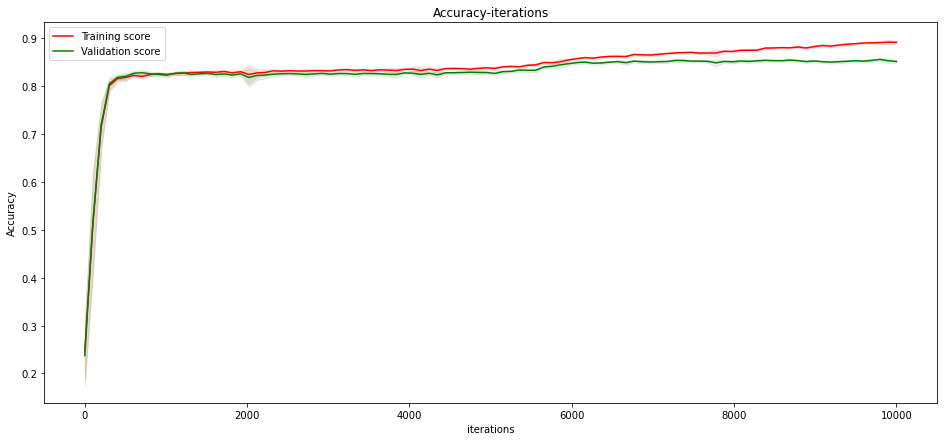

In [11]:
#learning curve visualization
train_acc = np.array(tarin_temp)
train_acc = np.resize(train_acc,(100,-1))
val_acc = np.array(test_temp)
val_acc = np.resize(val_acc,(100,-1))
train_acc_mean = train_acc.mean(axis=1)
train_acc_std = train_acc.std(axis=1)
val_acc_mean = val_acc.mean(axis=1)
val_acc_std = val_acc.std(axis=1)
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 7))
plt.title('Accuracy-iterations')
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.fill_between(np.linspace(0,training_epochs,100), train_acc_mean - train_acc_std,train_acc_mean + train_acc_std, alpha=0.1,color="r")
plt.fill_between(np.linspace(0,training_epochs,100), val_acc_mean - val_acc_std,val_acc_mean + val_acc_std, alpha=0.1,color="g")
plt.plot(np.linspace(0,training_epochs,100), train_acc_mean, color="r",label="Training score")
plt.plot(np.linspace(0,training_epochs,100), val_acc_mean, color="g",label="Validation score")
plt.legend(loc="best")